In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import time
import pandas as pd
import numpy as np
import joblib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from dask_ml.wrappers import ParallelPostFit

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
%%time
df = pd.read_csv('../data/new_balanced_data_500_preprocessed.csv')
df.tail()

Wall time: 96.4 ms


,short_descriptions,assignment_groups
111995,be can hcp not user,Service Desk - Sales All
111996,affiliation to,Service Desk - Sales All
111997,call to unable,Service Desk - Sales All
111998,question,Service Desk - Sales All
111999,into veeva,Service Desk - Sales All


In [3]:
df.columns

Index(['short_descriptions', 'assignment_groups'], dtype='object')

In [4]:
vectorizer = joblib.load('../models/vectorizer')
encoder = joblib.load('../models/encoder')

In [5]:
df.isna().sum() / len(df) * 100

short_descriptions    1.635714
assignment_groups     0.000000
dtype: float64

In [6]:
df.dropna(inplace=True)

In [7]:
df = df.sample(frac=1)

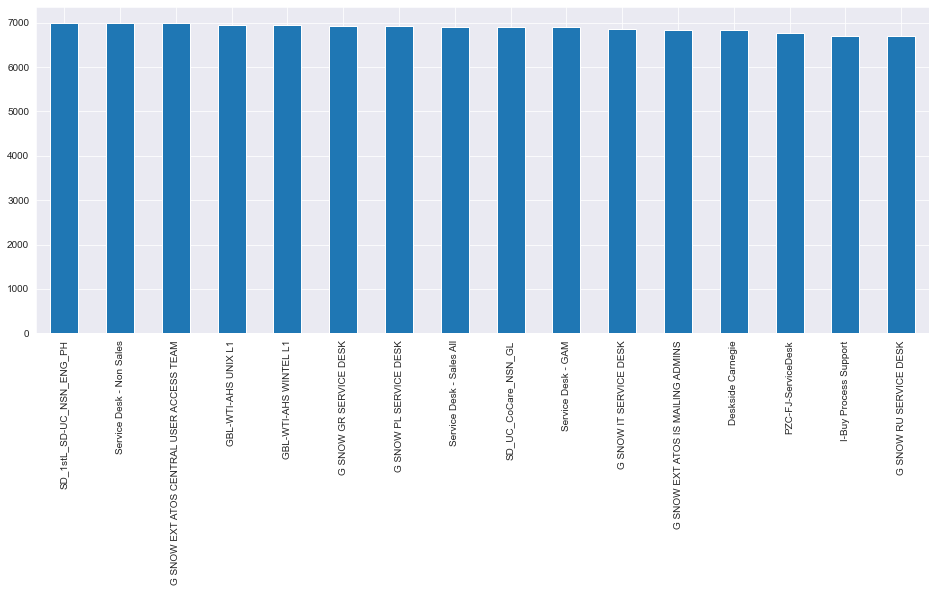

In [8]:
df['assignment_groups'].value_counts().plot(kind='bar', figsize=(16, 6))
plt.show()

In [9]:
X = df['short_descriptions'].values
y = df['assignment_groups'].values

In [10]:
X

array(['2020 do exist hr id idm not terminate week', 'invoice post',
       'email po of via re nonreceipt', ..., 'find ibuy in not supplier',
       'adobe request', 'niger node update'], dtype=object)

In [11]:
y

array(['G SNOW RU SERVICE DESK', 'SD_UC_CoCare_NSN_GL',
       'SD_1stL_SD-UC_NSN_ENG_PH', ..., 'I-Buy Process Support',
       'Service Desk - GAM', 'SD_UC_CoCare_NSN_GL'], dtype=object)

In [12]:
%%time
X = vectorizer.transform(X)

Wall time: 838 ms


In [13]:
%%time
y = encoder.transform(y.astype(str))

Wall time: 159 ms


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(88134, 25388) (88134,) (22034, 25388) (22034,)


In [16]:
models = [
    MultinomialNB(),
    LogisticRegression(n_jobs=-1),
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    DecisionTreeClassifier()
]


def display_metrics(true, pred):
    f1 = round(f1_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    precision = round(precision_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    recall = round(recall_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    acc = round(accuracy_score(y_true=y_test, y_pred=preds) * 100, 2)

    print(f'Accuracy: {acc} | F1: {f1} | Precision: {precision} | Recall: {recall}')
    
    return acc, f1, precision, recall

In [17]:
%%time

trained_models = dict()

for model in models:
    model_name = model.__class__.__name__
    print(f'Training -> {model_name}')
    
    s = time.time()
    
    predictor = ParallelPostFit(estimator=model)
    predictor.fit(X_train, y_train)
    
    e = time.time()
    
    print(f'Training time: {round(e - s)} seconds')
    
    preds = predictor.predict(X_test)
    
    acc, f1, precision, recall = display_metrics(true=y_test, pred=preds)
    
    trained_models[f1] = predictor   
    
    print('-' * 50)
    
final_model = max(sorted(trained_models.items(), reverse=True))[1]
print('Best model: ', final_model)

Training -> MultinomialNB
Training time: 0 seconds
Accuracy: 74.0 | F1: 74.03 | Precision: 74.76 | Recall: 74.0
--------------------------------------------------
Training -> LogisticRegression
Training time: 22 seconds
Accuracy: 79.25 | F1: 79.28 | Precision: 79.64 | Recall: 79.25
--------------------------------------------------
Training -> RandomForestClassifier
Training time: 365 seconds
Accuracy: 80.18 | F1: 79.84 | Precision: 81.02 | Recall: 80.18
--------------------------------------------------
Training -> LinearSVC
Training time: 25 seconds
Accuracy: 79.17 | F1: 79.19 | Precision: 79.68 | Recall: 79.17
--------------------------------------------------
Training -> DecisionTreeClassifier
Training time: 20 seconds
Accuracy: 76.98 | F1: 76.38 | Precision: 77.48 | Recall: 76.98
--------------------------------------------------
Best model:  ParallelPostFit(estimator=RandomForestClassifier(n_jobs=-1))
Wall time: 7min 14s


In [18]:
test = np.array([
    'HCP restriction removal'
])
test = vectorizer.transform(test)

In [19]:
prediction = final_model.predict(test)

In [20]:
display_metrics(true=y_train, pred=final_model.predict(X_train))

Accuracy: 76.98 | F1: 91.75 | Precision: 92.0 | Recall: 91.64


(76.98, 91.75, 92.0, 91.64)

In [21]:
joblib.dump(value=final_model, filename='../models/best_model.joblib', compress=2)

['../models/best_model.joblib']

In [22]:
report = classification_report(y_true=y_test, y_pred=final_model.predict(X_test), output_dict=True)

In [23]:
report_df = pd.DataFrame(report)

In [24]:
new_indices = list(
    encoder.inverse_transform(report_df.columns[:-3].astype('int'))
) + ['accuracy', 'macro avg', 'weighted avg']

In [25]:
report_df.columns = (new_indices)

In [26]:
report_df.T

,precision,recall,f1-score,support
Deskside Carnegie,0.655629,0.797802,0.719762,1365.000000
G SNOW EXT ATOS CENTRAL USER ACCESS TEAM,0.853128,0.674069,0.753101,1396.000000
G SNOW EXT ATOS IS MAILING ADMINS,0.807573,0.781601,0.794375,1337.000000
G SNOW GR SERVICE DESK,0.948263,0.941997,0.945120,1362.000000
G SNOW IT SERVICE DESK,0.949242,0.932986,0.941044,1343.000000
G SNOW PL SERVICE DESK,0.929252,0.970860,0.949600,1407.000000
G SNOW RU SERVICE DESK,0.736381,0.869180,0.797288,1353.000000
GBL-WTI-AHS UNIX L1,0.930663,0.876633,0.902840,1378.000000
GBL-WTI-AHS WINTEL L1,0.875605,0.910855,0.892882,1391.000000
I-Buy Process Support,0.769917,0.890855,0.825983,1356.000000


In [27]:
report_df.T.to_csv('../data/classification_report_500.csv')